In [ ]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import flygym
    FLYGYM_INSTALLED = True
except ImportError:
    FLYGYM_INSTALLED = False

if not FLYGYM_INSTALLED:
    if IN_COLAB:
        print("FlyGym not installed. I will try to install it now.")
        import subprocess
        subprocess.run('pip install "flygym[examples]" "mujoco==3.2.2" "dm_control==1.0.22"', shell=True)
    else:
        print(
            "FlyGym is not installed. I can try to install it here but I don't want "
            "to mess up your Python environment unintentionally. Please do it manually."
        )

if IN_COLAB:
    print("In Google Colab. I will now perform some Colab-specific setups.")
    # Set up GPU a few more and rendering parameters. This should take ~1 second.
    from google.colab import files
    import distutils.util
    import os
    import subprocess

    if subprocess.run("nvidia-smi").returncode:
        raise RuntimeError(
            "Cannot communicate with GPU. "
            "Make sure you are using a GPU Colab runtime. "
            "Go to the Runtime menu and select Choose runtime type."
        )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = "/usr/share/glvnd/egl_vendor.d/10_nvidia.json"
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, "w") as f:
            f.write(
"""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
"""
            )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print("Setting environment variable to use GPU rendering:")
    %env MUJOCO_GL=egl

    try:
        print("Checking that the installation succeeded:")
        import mujoco

        mujoco.MjModel.from_xml_string("<mujoco/>")
    except Exception as e:
        raise e from RuntimeError(
            "Something went wrong during installation. Check the shell output above "
            "for more information.\n"
            "If using a hosted Colab runtime, make sure you enable GPU acceleration "
            'by going to the Runtime menu and selecting "Choose runtime type".'
        )

    print("Installation successful.")

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange, tqdm

# Create output directory
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

In [2]:
# (Optional) Set up the xkcd style
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
plt.xkcd()

In this tutorial, we will simulate a virtual fly using vision to follow a target fly walking in a zig-zag pattern. First, let's explore how turning behavior can be implemented.

## Simple model of turning

We will use a 2-dimensional representation of descending signals $[\delta_L, \delta_R] \in \mathbb{R}^2$ to modulate the amplitude and direction of the leg CPGs on each side of the body. Specifically, we will modulate the intrinsic amplitude $R'$ and intrinsic frequency $\nu'$ on each side by:

$$
R'(\delta) = |\delta|
$$

$$
\nu_i'(\delta) = \begin{cases}
\nu_i   & \text{if } \delta>0\\
-\nu_i  & \text{otherwise}
\end{cases}
$$

In other words, the magnitude of the descending signal controls the amplitude of stepping (as a gain applied to the originally recorded step size); the sign of the descending signal controls the direction of stepping. Although simplified, this model provides a basic framework for turning. Future improvements could address the assumption of linear step size scaling.

The [flygym.examples.locomotion.HybridTurningFly](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/examples/locomotion/turning_fly.py) class implements this model. In the `__init__` method of this class, a CPG network is created for controlling the leg movements:

```Python
        ...

        # Initialize CPG network
        self.cpg_network = CPGNetwork(
                timestep=self.sim_params.timestep,
                intrinsic_freqs=intrinsic_freqs,
                intrinsic_amps=intrinsic_amps,
                coupling_weights=coupling_weights,
                phase_biases=phase_biases,
                convergence_coefs=convergence_coefs,
                seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)

        ...
```

During each simulation step, the CPG’s intrinsic amplitudes and frequencies are updated according to the descending signal:

```Python
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).ravel()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs
```

Next, these updated CPG phases and amplitudes are transformed into 7 joint angles for each of the six legs. This reduces the action space from 42 dimensions to just 2:

```Python
        for _ in range(n_steps):
            obs, _, _, _, info = sim.step(np.array([0.2, 1.4]))     # instead of sim.step({"joints": joint_angles_42_dim})
```

The class also detects if the fly is stuck or stumbling, adjusting its leg movements accordingly. For more details, refer to the [source code](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/examples/locomotion/turning_fly.py) of `HybridTurningFly` and the full tutorials on [hybrid controller](https://github.com/NeLy-EPFL/flygym/blob/main/notebooks/hybrid_controller.ipynb) and [hybrid turning controller](https://github.com/NeLy-EPFL/flygym/blob/main/notebooks/turning.ipynb).

Now, let's test the fly's turning by applying an asymmetric descending signal.

In [3]:
from flygym.arena import FlatTerrain
from flygym import Camera, SingleFlySimulation
from flygym.examples.locomotion import HybridTurningFly

# TODO: Change the descending signal to something asymmetric,
# which will cause the fly to turn:
descending_signal = np.array([1, 1])
###################################################################

timestep = 1e-4
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = HybridTurningFly(
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    enable_adhesion=True,
)
cam = Camera(fly=fly, camera_id="Animat/camera_top")
arena = FlatTerrain(ground_alpha=0.1)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)
obs, info = sim.reset(seed=0)
obs_hist = []
for _ in trange(4000):
    obs, _, _, _, info = sim.step(descending_signal)
    obs_hist.append(obs)
    sim.render()

cam.save_video(output_dir / "turning.mp4")

100%|██████████| 4000/4000 [00:09<00:00, 431.86it/s]


## Multi-Fly Simulation

Next, we will simulate two flies: one standing still and the other walking in a zig-zag pattern. The zig-zagging fly alternates between left and right turns, which can be achieved by setting the left and right descending signals to out-of-phase square waves.

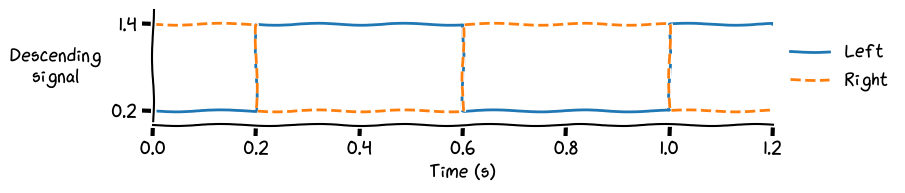

In [4]:
t = np.arange(0, 1.2, timestep)
right_descending_signal = ((t - 0.2) % 0.8 > 0.4) * 1.2 + 0.2
left_descending_signal = 1.6 - right_descending_signal
descending_signals = np.column_stack([left_descending_signal, right_descending_signal])

fig, ax = plt.subplots(figsize=(8, 1.5), sharex=True)
ax.plot(t, left_descending_signal, label="Left", lw=2)
ax.plot(t, right_descending_signal, label="Right", linestyle="--", lw=2)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.5), loc="center left")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Descending\nsignal", rotation=0, ha="center", va="center", labelpad=40)
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.6)
ax.set_yticks([0.2, 1.4])
ax.set_xticks(np.arange(0, 1.4, 0.2))
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

For multi-fly simulations, we use the `Simulation` class instead of `SingleFlySimulation`. The Simulation class accepts a list of `Fly` objects, each of which can be an instance of any subclass of the `Fly` class. In this case, we’ll simulate two `HybridTurningFly` instances, which we’ll name "Nuro" and "McFly."

In [5]:
from flygym import Simulation

nuro = HybridTurningFly(name="Nuro", spawn_pos=(-5, 1, 0.2), enable_adhesion=True, enable_vision=True, render_raw_vision=True, contact_sensor_placements=contact_sensor_placements)
mcfly = HybridTurningFly(name="McFly", spawn_pos=(0, 0, 0.2), enable_adhesion=True, contact_sensor_placements=contact_sensor_placements)
cam = Camera(fly=nuro, camera_id="Animat/camera_top_zoomout")
arena = FlatTerrain(ground_alpha=0.1)
sim = Simulation(
    flies=[nuro, mcfly],    # add both flies to the simulation
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)
obs, info = sim.reset(seed=0)

obs_hist = []
info_hist = []

for action_mcfly in tqdm(descending_signals):
    obs, _, _, _, info = sim.step(
        {
            "Nuro": np.zeros(2),    # stand still
            "McFly": action_mcfly,  # turn
        }
    ) 
    sim.render()

    obs_hist.append(obs)
    info_hist.append(info)

cam.save_video(output_dir / "multifly.mp4")

100%|██████████| 12000/12000 [01:55<00:00, 104.32it/s]


For multi-fly simulations, the action passed to the step method is a dictionary, with each fly's name as the key. Observations and info returned are also keyed by the flies' names.

In [6]:
print(f"{obs.keys()=}")
print(f"{obs['Nuro'].keys()=}")

obs.keys()=dict_keys(['Nuro', 'McFly'])
obs['Nuro'].keys()=dict_keys(['joints', 'fly', 'contact_forces', 'end_effectors', 'fly_orientation', 'cardinal_vectors', 'vision'])


### Visualizing Fly Trajectories
Let's visualize the trajectories of both flies as Nuro watches McFly walking away:

Text(0, 0.5, 'y (mm)')

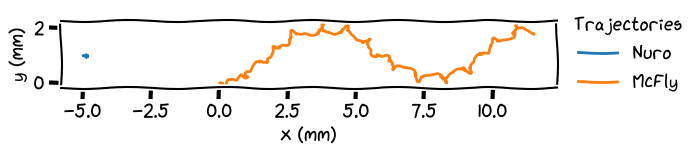

In [7]:
fig, ax = plt.subplots()

for fly in sim.flies:
    trajectory = np.array([i[fly.name]["fly"][0, :2] for i in obs_hist])
    ax.plot(trajectory[:, 0], trajectory[:, 1], label=fly.name)

ax.legend(frameon=False, title="Trajectories", bbox_to_anchor=(1, 0.5), loc="center left")
ax.set_aspect("equal")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

We will make Nuro follows McFly based on vision. Since `enable_vision=True` was set for Nuro, its observations include `vision`, an ndarray containing light intensities (ranging from 0 to 1) detected by its ommatidia.

In [8]:
print(f"{obs["Nuro"]["vision"].shape=}  # (number of retinas, number of ommatidia, number of channels)")

obs["Nuro"]["vision"].shape=(2, 721, 2)  # (number of retinas, number of ommatidia, number of channels)


These readings can be visualized using the `hex_pxls_to_human_readable` method of the `Retina` class.

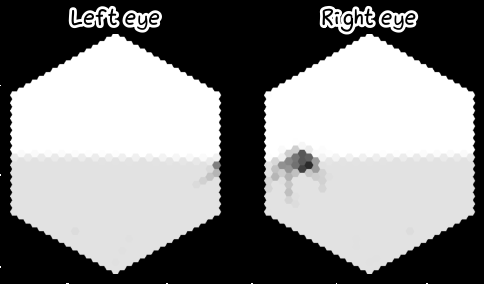

In [9]:
# take the maximum value across all channels
ommatidia_readings = obs_hist[50]["Nuro"]["vision"].max(axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(6, 4), facecolor="k")
for i, (ax, eye) in enumerate(zip(axs, ["Left", "Right"])):
    im = nuro.retina.hex_pxls_to_human_readable(ommatidia_readings[i])
    ax.imshow(im, cmap="gray", vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(f"{eye} eye")

As `enable_vision=True` was enabled during creation of Nuro, raw images (before conversion to ommatidia readings) are stored in the `raw_vision` field of the info dictionary.

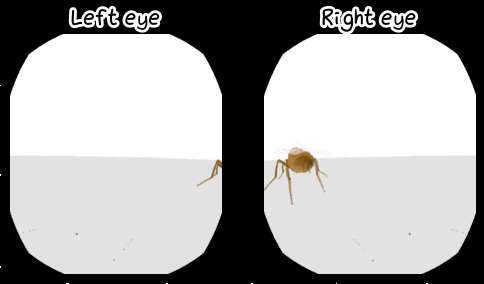

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4), facecolor="k")
for i, (ax, eye) in enumerate(zip(axs, ["Left", "Right"])):
    im = info_hist[50]["Nuro"]["raw_vision"][i].astype(np.uint8)
    ax.imshow(im, cmap="gray", vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(f"{eye} eye")

### Implementing Following Behavior
We’ll now implement a simple following behavior. Nuro will compare the numbers of dimmed ommatidia on its left and right retinas. If there are more dimmed ommatidia on the left, Nuro will turn left, otherwise, it will turn right.

Text(0.5, 0.15, 'L (2) < R (15) -> turn R')

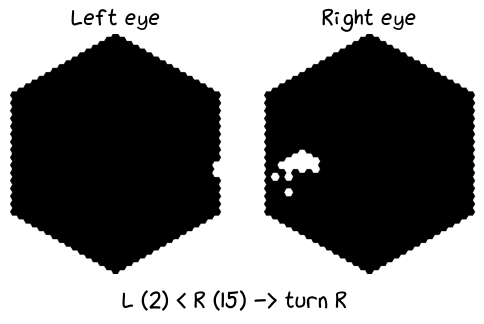

In [11]:
ommatidia_readings = obs_hist[50]["Nuro"]["vision"].max(axis=-1) # take the maximum value across all channels
threshold = 0.75

fig, axs = plt.subplots(1, 2, figsize=(6, 4))
for i, (ax, eye) in enumerate(zip(axs, ["Left", "Right"])):
    im = nuro.retina.hex_pxls_to_human_readable(ommatidia_readings[i])
    ax.imshow(im < threshold, cmap="gray", vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(f"{eye} eye")

ommatidia_l = (ommatidia_readings[0] < threshold).sum()
ommatidia_r = (ommatidia_readings[1] < threshold).sum()

fig.suptitle(f"L ({ommatidia_l}) {'<>'[int(ommatidia_l > ommatidia_l)]} R ({ommatidia_r}) -> turn {'RL'[int(ommatidia_l > ommatidia_l)]}", y=0.15)

In [12]:
nuro = HybridTurningFly(name="Nuro", contact_sensor_placements=contact_sensor_placements, enable_adhesion=True, spawn_pos=(-4.5, 0, 0.2), enable_vision=True, render_raw_vision=True)
mcfly = HybridTurningFly(name="McFly", contact_sensor_placements=contact_sensor_placements, enable_adhesion=True, spawn_pos=(0, 0, 0.2))
cam = Camera(fly=nuro, camera_id="Animat/camera_top_zoomout")
arena = FlatTerrain(ground_alpha=0.1)
sim = Simulation(
    flies=[nuro, mcfly],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)
obs, info = sim.reset(seed=0)

obs_hist = []
info_hist = []
is_left = []

action_nuro = np.zeros(2)
decision_interval = 500

for i, action_mcfly in enumerate(tqdm(descending_signals)):
    ommatidia_readings = obs["Nuro"]["vision"].max(-1)
    activated_ommatidia = (ommatidia_readings < 0.5).sum(-1)
    is_left.append(activated_ommatidia[0] > activated_ommatidia[1])
    
    if i > 0 and i % decision_interval == 0:
        # take the majority vote of the last `decision_interval` frames to
        # avoid frequent changes due to shaky vision
        if np.mean(is_left[-decision_interval:]) > 0.5:
            action_nuro = np.array([0.2, 1.4])
        else:
            action_nuro = np.array([1.4, 0.2])

    obs, _, _, _, info = sim.step({"Nuro": action_nuro, "McFly": action_mcfly})
    sim.render()

    obs_hist.append(obs)
    info_hist.append(info)

cam.save_video(output_dir / "nuro_follows_mcfly.mp4")

100%|██████████| 12000/12000 [01:53<00:00, 105.91it/s]


Let's visualize the trajectories of both flies as Nuro follows McFly.

Text(0, 0.5, 'y (mm)')

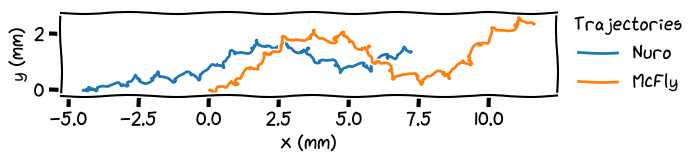

In [13]:
fig, ax = plt.subplots()

for fly in sim.flies:
    trajectory = np.array([i[fly.name]["fly"][0, :2] for i in obs_hist])
    ax.plot(trajectory[:, 0], trajectory[:, 1], label=fly.name)

ax.legend(frameon=False, title="Trajectories", bbox_to_anchor=(1, 0.5), loc="center left")
ax.set_aspect("equal")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

Finally, we can generate a video that shows Nuro's perspective as it follows McFly.

In [14]:
from flygym.vision import visualize_visual_input

visualize_visual_input(
    nuro.retina,
    output_path=output_dir / "nuro_follows_mcfly_retinal.mp4",
    vision_data_li=[obs["Nuro"]["vision"] for obs in obs_hist],
    raw_vision_data_li=[obs["Nuro"]["raw_vision"] for obs in info_hist],
    vision_update_mask=nuro.vision_update_mask,
    vision_refresh_rate=nuro.vision_refresh_rate,
    playback_speed=0.1,
)
plt.close()

## (Optional) Interfacing NeuroMechFly with a connectome-constrained vision model

Ultimately, to gain insights into the real workings of the biological controller, one would ideally build a controller with artificial neurons that can be mapped to neuron subtypes in the real fly nervous system. This can, in principle, be achieved by leveraging newly available brain and VNC connectomics datasets (see the [FlyWire](https://flywire.ai/) project for the brain, and the [FANC](https://connectomics.hms.harvard.edu/project1) and [MANC](https://www.janelia.org/project-team/flyem/manc-connectome) projects for the VNC).

To illustrate how this might be accomplished, we will interface NeuroMechFly a recently established connectome-constrained neural network model ([Lappalainen et al., 2024](https://www.nature.com/articles/s41586-024-07939-3); [code](https://github.com/TuragaLab/flyvis)). This study has constructed an artificial neural network (ANN) representing the retina, lamina, medula, lobula plate, and lobula of the fly visual system (see figure below). The connectivity in this network is informed by the connectome and, unlike typical ANNs, models biologically meaningful variables such as voltage.

<p align="center">
<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/advanced_vision/lappalainen_model_schematic.png?raw=true" alt="lappalainen_model_schematic.png" width="500"/>
</p>

_Image from Lappalainen et al., 2024._

We will pass the visual experience of the simulated fly as inputs to this pretrained model and simulate the activities of real neurons. For this purpose, we have implemented a `RealisticVisionFly` class that extends `HybridTurningFly`. Let's initialize the simulation but replace the observer fly with an instance of `RealisticVisionFly`:

In [15]:
from flygym.examples.vision import RealisticVisionFly

nuro = RealisticVisionFly(name="Nuro", spawn_pos=(-5, 1, 0.2), enable_adhesion=True, contact_sensor_placements=contact_sensor_placements)
mcfly = HybridTurningFly(name="McFly", spawn_pos=(0, 0, 0.2), enable_adhesion=True, contact_sensor_placements=contact_sensor_placements)
cam = Camera(fly=nuro, camera_id="Animat/camera_top_zoomout")
arena = FlatTerrain(ground_alpha=0.1)
sim = Simulation(
    flies=[nuro, mcfly],    # add both flies to the simulation
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

/Users/tlam/flygym/flygym/examples/vision/vision_network.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.dir / chkpt, map_location=flyvisi

Let's revisit the scenario when Nuro stands still and McFly walks in a zig-zag pattern and see how different classes of neurons in the vision model respond to the moving fly.

In [16]:
obs, info = sim.reset(seed=0)
viz_data_all = []
obs_hist = []
info_hist = []

for action in tqdm(descending_signals[:4000]):  # only simulate the first 4000 steps to save time
    obs, _, _, _, info = sim.step(
        {
            "Nuro": np.zeros(2),    # stand still
            "McFly": action,        # turn
        }
    ) 
    obs_hist.append(obs)
    info_hist.append(info)

    rendered_img = sim.render()[0]

    if rendered_img is not None:
        viz_data = {
            "rendered_image": rendered_img,
            "vision_observation": obs["Nuro"]["vision"],  # raw visual observation
            "nn_activities": info["Nuro"]["nn_activities"],  # neural activities
        }
        viz_data_all.append(viz_data)

100%|██████████| 4000/4000 [07:18<00:00,  9.12it/s]


In [17]:
from flygym.examples.vision.viz import visualize_vision

plt.rcdefaults()
plt.ioff()

visualize_vision(
    video_path=output_dir / "two_flies_walking_vision.mp4",
    retina=nuro.retina,
    retina_mapper=nuro.retina_mapper,
    viz_data_all=viz_data_all,
    fps=cam.fps,
)
plt.close()

 98%|█████████▊| 59/60 [00:46<00:00,  1.29it/s]

From the "info" dictionary, we can get the "nn_activities" entry, which is an extended dictionary containing the current activities of all neurons simulated in the network. For a complete definition of what the simulation returns in the observation and "info" dictionary, please refer to the [MDP Task Specification page](https://neuromechfly.org/api_ref/mdp_specs.html) of the API reference.

In [19]:
print(info["Nuro"]["nn_activities"].keys())

dict_keys(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'L1', 'L2', 'L3', 'L4', 'L5', 'Lawf1', 'Lawf2', 'Am', 'C2', 'C3', 'CT1(Lo1)', 'CT1(M10)', 'Mi1', 'Mi2', 'Mi3', 'Mi4', 'Mi9', 'Mi10', 'Mi11', 'Mi12', 'Mi13', 'Mi14', 'Mi15', 'T1', 'T2', 'T2a', 'T3', 'T4a', 'T4b', 'T4c', 'T4d', 'T5a', 'T5b', 'T5c', 'T5d', 'Tm1', 'Tm2', 'Tm3', 'Tm4', 'Tm5Y', 'Tm5a', 'Tm5b', 'Tm5c', 'Tm9', 'Tm16', 'Tm20', 'Tm28', 'Tm30', 'TmY3', 'TmY4', 'TmY5a', 'TmY9', 'TmY10', 'TmY13', 'TmY14', 'TmY15', 'TmY18'])


As an example, we can access the activities of the T4a/b/c/d neurons, which are known for encoding optical flow:

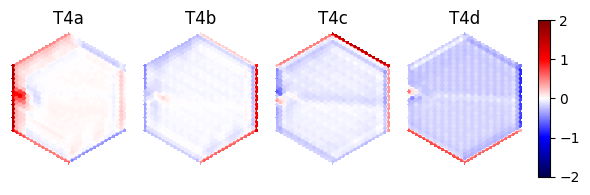

In [20]:
import matplotlib.pyplot as plt

plt.ion()

fig, axs = plt.subplots(
    1, 5, figsize=(6, 2), width_ratios=[2, 2, 2, 2, 0.2], tight_layout=True
)

for i, cell in enumerate(["T4a", "T4b", "T4c", "T4d"]):
    ax = axs[i]

    # Take the cell activities of the right eye (index 1)
    cell_activities = info["Nuro"]["nn_activities"][cell][1]
    cell_activities = nuro.retina_mapper.flyvis_to_flygym(cell_activities)

    # Convert the values of 721 cells to a 2D image
    viz_img = nuro.retina.hex_pxls_to_human_readable(cell_activities)
    viz_img[nuro.retina.ommatidia_id_map == 0] = np.nan
    imshow_obj = ax.imshow(viz_img, cmap="seismic", vmin=-2, vmax=2)
    ax.axis("off")
    ax.set_title(cell)

cbar = plt.colorbar(
    imshow_obj,
    cax=axs[4],
)

Can you think of a way to use the activities of the neurons (e.g., T4a/b/c/d) in the vision model to make Nuro follow McFly more effectively?

In [ ]:
from flygym.examples.vision import RealisticVisionFly

nuro = RealisticVisionFly(name="Nuro", spawn_pos=(-5, 1, 0.2), enable_adhesion=True, contact_sensor_placements=contact_sensor_placements)
mcfly = HybridTurningFly(name="McFly", spawn_pos=(0, 0, 0.2), enable_adhesion=True, contact_sensor_placements=contact_sensor_placements)
cam = Camera(fly=nuro, camera_id="Animat/camera_top_zoomout")
arena = FlatTerrain(ground_alpha=0.1)
sim = Simulation(
    flies=[nuro, mcfly],    # add both flies to the simulation
    cameras=[cam],
    arena=arena,
)

obs, info = sim.reset(seed=0)
viz_data_all = []
obs_hist = []
info_hist = []

for action_mcfly in tqdm(descending_signals):
    # Modulate the descending signals with activities of neurons such as T4a/b/c/d
    action_nuro = ...

    obs, _, _, _, info = sim.step(
        {
            "Nuro": action_nuro,
            "McFly": action_mcfly,
        }
    ) 
    obs_hist.append(obs)
    info_hist.append(info)

    rendered_img = sim.render()[0]

    if rendered_img is not None:
        viz_data = {
            "rendered_image": rendered_img,
            "vision_observation": obs["Nuro"]["vision"],  # raw visual observation
            "nn_activities": info["Nuro"]["nn_activities"],  # neural activities
        }
        viz_data_all.append(viz_data)

cam.save_video(output_dir / "realistic_vision_top_view.mp4")

plt.rcdefaults()
plt.ioff()

visualize_vision(
    video_path=output_dir / "realistic_vision_activities.mp4",
    retina=nuro.retina,
    retina_mapper=nuro.retina_mapper,
    viz_data_all=viz_data_all,
    fps=cam.fps,
)
plt.close()